### image captioning

This notebook base on [nttuan8 blog](https://nttuan8.com/).

We build model to convert content in the image to text, this is called `image_captioning`, follow this processing: `image` -> `text` -> `voice`

**Usages**:

- For helping elders who have weak eyes can understand what is going on around them.

- search image follow the caption

We can download the dataset [here](https://academictorrents.com/details/9dea07ba660a722ae1008c4c8afdd303b6f6e53b), they have `8000` samples.

- `6000` for training set meaning `75%`

- `1000` for validation set `12.5%`

- `1000` for testing set `12.5%`

Your `Flickr8k` download will contain 2 floder: 

- floder `Images`: contain the images

- text file `captions`: contain the captions

![workflow](image_captioning.png)

**Image embedding with Inception**

![inception](inception.png)

In this notebook we will using pre-trained model `Inception v3` with dataset `ImageNet` to get the `embedding vector`

- The input shape `229x229x3` (we will resize the input)
- The `embedding vector`: `256x1`

**Text processing**
We will process the text input before give it to the `RNNs` model, Follow these steps:
- *Step1*: convert text from uppercase to lowercase, ex: "Hello" -> "hello"
- *Step2*: Remove the special character, ex: "@#$%^&"
- *Step3*: Remove the text-num charater: ex "hey199"
- *Step4*: we add `startseq` and `endseq` for notice the begin and ending of the caption, ex: "startseq a girl going to wooden building endseq"

We need to check how many unique character in the `8000*5` captions, but we don't care about the charater just appear few time (Someone treat them like noise and useless) so we need to set a `accept_range` for each word's appearance

We also check the longest caption (maybe 34 characters) and add `padding` to let caption's lenght equal, ex: " A", " A girl going", " A girl going into a wooden". So we got `total_character` =  `unique_charater` + `1 padding character`

**Word embedding**

You have to convert text to number (this called: word embedding), there is 1 famous word embedding name `word2vec` published by Google

- One hot encoding: This is a easiest way to convert text to vector have the lenght equal to the lenght of your dictionary, but if your diction is to large, may be > 10,000 words, that will be a big memory problem, and also the distance from similar words did not count.

- Co-ocurrence matrix: In 1957 J.R.Firth said: "You can understand meaning of a word by the nearly words", `co-occurrence matrix` based on this idea. but there are some defect:
    + when the dictionary size increase the `matrix_dimension` is increase too
    + storage a `co-occurence matrix` need large memory
    + there is so many zero value in the matrix
    to descrease `co-ocurrence matrix` size, we use `SVD` (singular value decomposition), with `m` is the dimension of the `co-occurence matrix` and `n` is the dimension of matrix after `SVD` `n` < `m`?$ O(mn^{2})$, and it is hard to add new word inside your matrix
    
- Word to vector (word2vec):
    Mikolov said the meaning of the word and the the context is strong correlation
    + `word2vec` trying to predict the nearly word, not counting them
    It make the calculation is faster and easier to transfer learning when we add new word into the dictionary
    `word2vec` trying to predict the words around in the radius `m`:
    $$J_{{\theta}} = -\frac{1}{T} \prod_{i=1}^{T} \prod_{j=-m,j\neq0}^{m}p (w_{t+j}|w_t;\theta)$$
    
    There are 2 architecture `CBoW`,`Skip-Gram`
    + `CBoW`: need a context then it will predict the word, ex: "I ... you" -> Love
    + `Skip-Gram`: given a text then we trying to predict a context (the rest of words), ex: Love -> "I ... you"

![cbow_skip-gram](cbow_skip-gram.png)

 pretrained model `GLoVe` [GloVe stanford](https://nlp.stanford.edu/projects/glove/) [GloVe Kaggle](https://www.kaggle.com/datasets/anindya2906/glove6b?select=glove.6B.200d.txt)

In [1]:
from google.colab import drive
drive.mount('./drive')

Mounted at ./drive


In [2]:
import os

In [3]:
os.listdir('/content/drive/MyDrive/Flickr8k')

['captions.txt', 'Images']

In [4]:
# show how many image in Images floder
imgs = os.listdir('/content/drive/MyDrive/Flickr8k/Images')
print(f'so we have: {len(imgs)}')
print(f'meaning we have: {len(imgs)*5} caption')

so we have: 8091
meaning we have: 40455 caption


In [5]:
import glob

In [6]:
# Check the number of images again with glob
imgs = glob.glob('/content/drive/MyDrive/Flickr8k/Images/' +'*.jpg')
print(f'actually we have: {len(imgs)} imgs')

actually we have: 8091 imgs


In [7]:
# read the caption file
def load_doc(filename):
    # open the file as read only
    file = open(filename,'r')
    # read all text
    text = file.read()
    # close file
    file.close()
    return text

captions = load_doc('/content/drive/MyDrive/Flickr8k/captions.txt')
print(f'captions: {type(captions)}')
print(f'captions lenght: {len(captions)}')
captions = captions.split('\n')
captions[:5]

captions: <class 'str'>
captions lenght: 3319294


['image,caption',
 '1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .']

In [8]:
# remove the first element in the list
captions.pop(0)
print(f'captions: {type(captions)}')
print(f"captions lenght: {len(captions)}")
captions[:5]

captions: <class 'list'>
captions lenght: 40456


['1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .']

In [9]:
print(f'the last caption: {captions[-1]}')
captions.pop(-1)
print(f"captions'slenght: {len(captions)}")

the last caption: 
captions'slenght: 40455


In [10]:
# convert captions to this form id_image: [caption1,caption2,caption3,caption4,caption5]
# get all image name
imgs = []
for i in range(len(captions)):
    img = captions[i].split(',')
    img = img[0]
    imgs.append(img)
    
print(f'imgs lenght before set: {len(imgs)}')

# get the unique image name
imgs= set(imgs)
print(f'imgs lenght after set: {len(imgs)}')

imgs lenght before set: 40455
imgs lenght after set: 8091


In [11]:
captions[0].split(",")

['1000268201_693b08cb0e.jpg',
 'A child in a pink dress is climbing up a set of stairs in an entry way .']

In [12]:
# create a dict with image name
img_dict = {}
for img in imgs:
    img_dict[img] = []

for img_cap in captions:
    img_cap = img_cap.split(',')
    img,cap = img_cap[0],img_cap[-1]
    img_dict[img].append(cap)

In [13]:
import random

In [14]:
# test our list
img = random.choice(list(imgs))
caps = img_dict[img]
print(f'img: {img}')
print(f'cap lenght: {len(caps)}')
print(caps)

img: 3597924257_d0da3c5fe6.jpg
cap lenght: 5
['A brown and white dog runs in a field of yellow flowers .', 'A brown dog running at a lean across a lawn .', 'A brown dog runs through a field of grass spotted with yellow flowers', 'The brown dog runs through the field .', 'The tan and white dog is running in the field .']


In [15]:
import string

In [16]:
# prepare translation table for removing punctuation
table = str.maketrans('', '', string.punctuation)
table

{33: None,
 34: None,
 35: None,
 36: None,
 37: None,
 38: None,
 39: None,
 40: None,
 41: None,
 42: None,
 43: None,
 44: None,
 45: None,
 46: None,
 47: None,
 58: None,
 59: None,
 60: None,
 61: None,
 62: None,
 63: None,
 64: None,
 91: None,
 92: None,
 93: None,
 94: None,
 95: None,
 96: None,
 123: None,
 124: None,
 125: None,
 126: None}

In [17]:
for img,cap_list in img_dict.items():
    # loop over each caption 
    for i,cap in enumerate(cap_list):
        # slpit the cap each word
        cap = cap.split()
        # convert to lower case
        cap = [word.lower() for word in cap]
        # remove punctuation from each token
        cap = [word.translate(table) for word in cap]
        # remove hanging 's' and 'a'
        cap = [word for word in cap if len(word) >1]
        # remove word with number 
        cap = [word for word in cap if word.isalpha()]
        # merge each word become a string again
        cap_list[i] = ' '.join(cap)

In [18]:
# test our list
img = random.choice(list(imgs))
caps = img_dict[img]
print(f'img: {img}')
print(f'cap lenght: {len(caps)}')
print(caps)

img: 1449625950_fc9a8d02d9.jpg
cap lenght: 5
['brown dog and tan dog are playing in tall grass', 'there is white dog and chocolate colored dog running in the grass', 'two dogs are playing together in the grass', 'two dogs play in grassy field', 'two dogs running on grass']


In [23]:
# save your caption
def save_captions(captions,filename):
    lines = list()
    for img,cap_list in captions.items():
        for cap in cap_list:
            lines.append(img + ',' + cap)
        data = '\n'.join(lines)
        file =  open(filename,'w')
        file.write(data)
        file.close()

# we did make the clean_caps.txt      
save_captions(img_dict,'./clean_caps.txt')

In [24]:
docs = load_doc('/content/drive/MyDrive/clean_caps.txt')
for i,img in enumerate(imgs):
  print(img)

Streaming output truncated to the last 5000 lines.
3430526230_234b3550f6.jpg
3255620561_7644747791.jpg
2618322793_5fb164d86a.jpg
1234817607_924893f6e1.jpg
2899501488_90d5da5474.jpg
424869823_7aec015d87.jpg
317488612_70ac35493b.jpg
3242808166_8638150274.jpg
3038941104_17ee91fc03.jpg
1643915227_9f48068772.jpg
495116214_f1df479fb0.jpg
146098876_0d99d7fb98.jpg
3046431231_dc48851062.jpg
416788726_5b4eb1466e.jpg
3470129475_9e58b6742c.jpg
2471974379_a4a4d2b389.jpg
3486340101_ff01d8f3f9.jpg
3649224118_abe73c672c.jpg
497579819_f91b26f7d3.jpg
2297471897_3419605c16.jpg
3744832122_2f4febdff6.jpg
337793983_ac5b2e848e.jpg
3424605029_53078d3505.jpg
2886837407_a4510ab1ef.jpg
2076428547_738e0a132f.jpg
1472882567_33dc14c8b6.jpg
2518853257_02f30e282e.jpg
3560977956_e08d2cd531.jpg
362316425_bda238b4de.jpg
472661386_723aae880b.jpg
2057305043_952b8dc82c.jpg
2831217847_555b2f95ca.jpg
3256274183_4eab3b2322.jpg
3092756650_557c5f2d03.jpg
3454988449_1de1ef4f20.jpg
278388986_78ba84eb8f.jpg
3221036999_3f7b152d8a.j

In [25]:
def load_captions(filename,image_path):
    # load the value
    doc = load_doc(filename)
    img_dict = {} # dict()
    # get image key
    imgs = glob.glob(image_path +'*.jpg')
    for i,img in enumerate(imgs):
        img = img.split('/')[-1]
        #update correct key word again
        imgs[i] = img
        img_dict[img] = []
    #print(img_dict)
    # get caption list    
    for line in doc.split('\n'):
        tokens = line.split(',')
        # get image name and caption (image,caption)
        img,cap= tokens[0],tokens[1:]
        if img in imgs:
            # add startseq and endseq
            cap = 'startseq ' + ' '.join(cap) + ' endseq'
            # store
            img_dict[img].append(cap)
    return img_dict

img_dict = load_captions('./clean_caps.txt','/content/drive/MyDrive/Flickr8k/Images/')

In [26]:
img_dict

{'374124237_51f62b6937.jpg': ['startseq girl dressed in black is posing for the camera endseq',
  'startseq woman dressed in black endseq',
  'startseq woman in black clothes with one leg up endseq',
  'startseq woman in black leggings and beige cowboy boots endseq',
  'startseq and some kicking boots endseq'],
 '397982550_cf9f5cdb74.jpg': ['startseq bald man stands in snowy side street endseq',
  'startseq bald man wearing jacket looks at icy sidewalk endseq',
  'startseq man is standing on an icy street with building beside him endseq',
  'startseq man wearing gray coat looks to the right on snowy street endseq',
  'startseq man wearing grey jacket standing on the side of street endseq'],
 '3736786640_70df13be2c.jpg': ['startseq two boys are playing on trampoline endseq',
  'startseq two kids in black trunks bouncing on wet trampoline endseq',
  'startseq two teenage boys in black swim trunks play on trampoline endseq',
  'startseq two wet boys in swim trunks are sitting on trampolin

In [27]:
# test our list, create imgs set from caption again before run this code
img = random.choice(list(imgs))
caps = img_dict[img]
print(f'img: {img}')
print(f'cap lenght: {len(caps)}')
print(caps)

img: 716597900_b72c58362c.jpg
cap lenght: 5
['startseq an adult and three children walk along the beach endseq', 'startseq woman and three children walk on the beach in line endseq', 'startseq woman is walking along the beach with three children following behind her endseq', 'startseq woman walks along the beach as three children follow her in line endseq', 'startseq the boys follow their mother on the beach endseq']


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import InceptionV3

In [29]:
# load image and proprocess into Inception v3
def preprocess(image_path):
    # convert all the images to size 299x299 as excepted by the inception v3 model
    img = image.load_img(image_path,target_size=  (299,299))
    # convert image into array
    x= image.img_to_array(img)
    # add 1 dimension as 1 simple
    x = np.expand_dims(x,axis =0) # (n_sample,width,height,colors)
    # preprocess_input
    x = preprocess_input(x) # scale it from 0-255 to 0-1 
    return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


startseq float representing the times of hanging is shown in the back of truck endseq
startseq man in judge costume stand on red truck and hangs dummy endseq
startseq man dressed as judge pretending to hang another man on top of truck endseq
startseq three people in costumes stand on the back of pickup truck endseq
startseq three people stand on the back of truck endseq


Text(0.5, 1.0, '2661294969_1388b4738c.jpg')

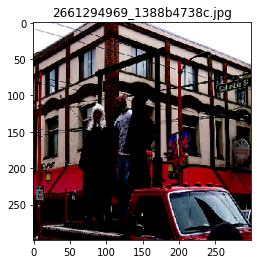

In [30]:
# test your preprocess input
img = random.choice(list(imgs))
x  = preprocess('/content/drive/MyDrive/Flickr8k/Images/' + img)
for cap in img_dict[img]:
    print(cap)
plt.imshow(x[0])
plt.title(img)

In [31]:
# load inception v3 model
model = InceptionV3(weights = 'imagenet')

96124928/96112376 [==============================] - 1s 0us/step


In [32]:
# check model summary
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [33]:
from keras.models import Model

In [34]:
# remove the last layer for feature extraction
feature_extractor = Model(model.input,model.layers[-2].output) # -1 is the last
feature_extractor.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [35]:
# image embedding with feature_extractor
def encode(image,feature_extractor):
    image = preprocess(image) # convert image model input
    feature_vector = feature_extractor.predict(image) # get the encoding vector for the image
    feature_vector = np.ravel(feature_vector) # reshape (1,2048) to (2048,)
    return feature_vector

img = random.choice(list(imgs))
feature_vector = encode('/content/drive/MyDrive/Flickr8k/Images/' + img,feature_extractor)
print(feature_vector.shape)

(2048,)


In [36]:
# split train-valid-test
full_images = list(imgs)
train_images = full_images[:6000]
valid_images = full_images[6000:7000]
test_images = full_images[7000:]
print(f'full_images: {len(full_images)}')
print(f'train_images: {len(train_images)}')
print(f'valid_images: {len(valid_images)}')
print(f'test_images: {len(test_images)}')

full_images: 8091
train_images: 6000
valid_images: 1000
test_images: 1091


In [39]:
'3737711435_113ccd0a52.jpg' in train_images

True

In [40]:
from time import time
from tqdm import tqdm

In [41]:
# encode all image in train set
start = time()
encoding_train = {}
for img in tqdm(train_images):
    encoding_train[img] = encode('/content/drive/MyDrive/Flickr8k/Images/' + img,feature_extractor)
print("Time taken in seconds = ",time()-start)

100%|██████████| 6000/6000 [30:39<00:00,  3.26it/s]

Time taken in seconds =  1839.2253859043121


In [42]:
from pickle import dump,load

In [43]:
# store your encode image
with open('./encoded_train_images.pkl','wb') as encoded_pickle:
    dump(encoding_train,encoded_pickle)

In [44]:
# move to drive
!cp ./encoded_train_images.pkl /content/drive/MyDrive

In [45]:
# encode all image in valid set
start = time()
encoding_valid = {}
for img in tqdm(valid_images):
    encoding_valid[img] = encode('/content/drive/MyDrive/Flickr8k/Images/' + img,feature_extractor)
print("Time taken in seconds = ",time()-start)

100%|██████████| 1000/1000 [05:04<00:00,  3.28it/s]

Time taken in seconds =  304.85265350341797


In [46]:
# store your encode image
with open('./encoded_valid_images.pkl','wb') as encoded_pickle:
    dump(encoding_valid,encoded_pickle)

In [47]:
# move to drive
!cp ./encoded_valid_images.pkl /content/drive/MyDrive

In [48]:
# encode all image in test set
start = time()
encoding_test = {}
for img in tqdm(test_images):
    encoding_test[img] = encode('/content/drive/MyDrive/Flickr8k/Images/' + img,feature_extractor)
print("Time taken in seconds = ",time()-start)

100%|██████████| 1091/1091 [05:39<00:00,  3.21it/s]

Time taken in seconds =  339.9790349006653


In [49]:
# store your encode image
with open('./encoded_test_images.pkl','wb') as encoded_pickle:
    dump(encoding_test,encoded_pickle)

In [50]:
# move to drive
!cp ./encoded_test_images.pkl /content/drive/MyDrive

In [51]:
# load train-valid-test feature
train_features = load(open('/content/encoded_train_images.pkl','rb'))
print(f'train features: {len(train_features)}')
valid_features = load(open('/content/encoded_valid_images.pkl','rb'))
print(f'valid features: {len(valid_features)}')
test_features = load(open('/content/encoded_test_images.pkl','rb'))
print(f'test features: {len(test_features)}')

train features: 6000
valid features: 1000
test features: 1091


In [52]:
# create a dict of training captions
all_train_captions = []
for img in train_images:
  captions = img_dict[img]
  for caption in captions:
    all_train_captions.append(caption)
print(f'all train captions: {len(all_train_captions)}')

all train captions: 30000


In [53]:
# create a list of all valid captions
all_valid_captions = []
for img in valid_images:
  captions = img_dict[img]
  for caption in captions:
    all_valid_captions.append(caption)
print(f'all valid captions: {len(all_valid_captions)}')

all valid captions: 5000


In [54]:
# create a list of all test captions
all_test_captions = []
for img in test_images:
  captions = img_dict[img]
  for caption in captions:
    all_test_captions.append(caption)
print(f'all test captions: {len(all_test_captions)}')

all test captions: 5455


In [55]:
# create a train dictionary and just take the word apear 10 time
word_count_threshold = 10
word_counts = {}
for sent in all_train_captions:
  for word in sent.split(' '):
    word_counts[word] = word_counts.get(word,0) + 1  # count the word 

vocab = [word for word in word_counts if word_counts[word] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts),len(vocab)))

preprocessed words 7529 -> 1609


In [56]:
ixtoword = {} # id_number : word
wordtoix = {} # word : id_number
ix = 1
for word in vocab:
  wordtoix[word] = ix
  ixtoword[ix] = word 
  ix +=1

In [57]:
vocab_size = len(ixtoword) +1 # add 1 for padding word " "
vocab_size

1610

In [58]:
# create a dictionary of the train
train_dict = {}
for img in train_images:
  train_dict[img] = img_dict[img]

In [59]:
# convert a dictionary of clean captions to a list of captions
def to_lines(img_caps):
  all_caps = list() # or []
  for key in img_caps.keys():
    [all_caps.append(cap) for cap in img_caps[key] ]
  return all_caps

# find the maximum length of the
def max_length(img_caps):
  lines = to_lines(img_caps)
  return max(len(line.split()) for line in lines) # split caption by padding then count the word

# determine the maximum sequence length of captions
max_length = max_length(train_dict)
print(f'Captions length: {max_length}')

Captions length: 31


In [60]:
# load glove model
glove_dir = ''
embeddings_index = {} # empty dictionary
f = open('/content/drive/MyDrive/glove.6B.200d.txt/glove.6B.200d.txt',encoding = 'utf-8')

for line in tqdm(f):
  values = line.split() # 200 dimension and 1 word
  word = values[0]
  coefs = np.asarray(values[1:],dtype = 'float32')
  embeddings_index[word] = coefs 

f.close()
print('Found %s word vectors.' % len(embeddings_index))

400000it [00:20, 19089.36it/s]


Found 400000 word vectors.


In [61]:
# check the vector of the random word
word = random.choice(vocab)
print(f'{word} \nvetor {embeddings_index[word].shape} \n{embeddings_index[word]}')

brown 
vetor (200,) 
[-3.1442e-01 -4.6750e-01 -8.4407e-01 -1.8710e-01 -1.2632e-01  1.2006e-01
  5.6806e-02 -3.4877e-01 -6.7246e-02 -1.0056e-01  2.0937e-01 -2.3444e-01
 -3.0512e-01  1.2300e-01  6.8152e-01  3.3224e-01 -1.5463e-01 -6.3934e-02
  2.9683e-01  2.1666e-01  1.8406e-01  1.6954e+00 -2.8552e-01  3.1491e-01
  3.9817e-03 -3.4663e-01 -3.1703e-01 -3.8260e-01 -3.0899e-01 -7.5480e-02
  1.9759e-01 -4.5206e-01  2.2378e-02  7.8655e-02  2.3765e-01 -1.2059e-01
  3.2246e-01 -6.3736e-01 -3.3414e-01 -4.6758e-01 -5.2968e-01  8.0329e-02
 -4.2745e-02  4.5676e-01 -3.0410e-02 -4.2255e-02  1.1239e+00 -4.0934e-01
  6.2239e-01  1.8442e-01  3.4795e-01  3.9478e-01 -4.1470e-01  3.3069e-01
  5.3098e-01 -5.7980e-01 -4.0896e-01 -3.7668e-03  1.6660e-01 -3.7549e-01
  5.9203e-01  4.2156e-01 -3.5300e-01 -2.3176e-01 -1.7937e-01 -6.2997e-01
  2.4777e-01  1.1116e+00  3.1387e-01  5.1727e-01 -4.7342e-02  7.8297e-02
 -2.4665e-02  4.7672e-01 -3.4149e-02 -5.8473e-01 -3.0589e-01 -3.0829e-01
  1.7088e-02  4.3659e-02  2.56

In [62]:
embedding_dim = 200
# create embedding matrix
embedding_matrix = np.zeros((vocab_size,embedding_dim)) # (number of vocab,dimensions)
print(f'embedding_matrix: {embedding_matrix.shape}') # padding word will get zero

for word,i in wordtoix.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    # words not found in the embedding index will be all zeros
    embedding_matrix[i] = embedding_vector

embedding_matrix: (1610, 200)


In [63]:
from keras.layers.merge import add
from keras.layers import Input,Dense,LSTM,Dropout,Embedding
from tensorflow.keras.utils import plot_model

In [64]:
print(f'vocab_size: {vocab_size}')
print(f'embedding_dim: {embedding_dim}\n')

# build model
input1 = Input(shape = (2048,))
fe1 = Dropout(0.5)(input1)
fe2 = Dense(256,activation = 'relu')(fe1)
input2 = Input(shape = (max_length,))
se1 = Embedding(vocab_size,embedding_dim,mask_zero = True)(input2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2,se3])
decoder2 = Dense(256,activation = 'relu')(decoder1)
output = Dense(vocab_size,activation = 'softmax')(decoder2)
model_word = Model(inputs = [input1,input2],outputs = output)
model_word.summary()

vocab_size: 1610
embedding_dim: 200

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 31)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 31, 200)      322000      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                       

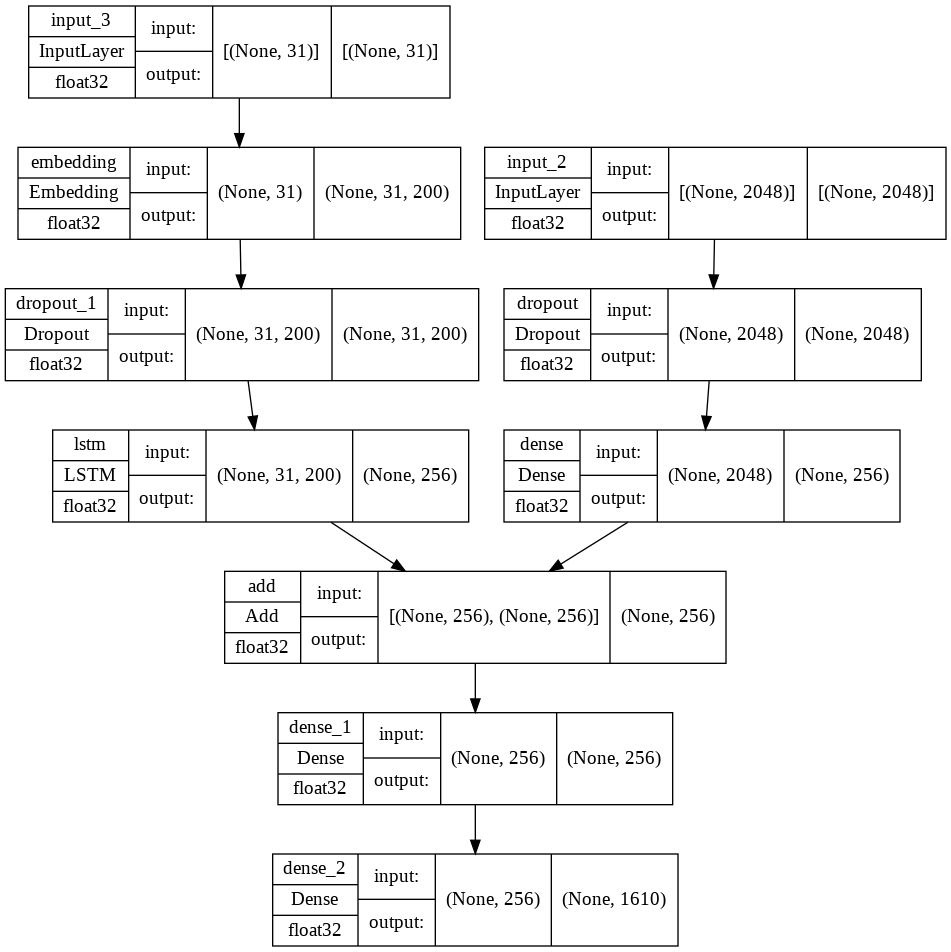

In [65]:
plot_model(model_word,
           to_file='model_word.png',
           show_shapes=True,
           show_dtype=True,
           show_layer_names=True
           )

In [66]:
print(f'embedding_matrix: {embedding_matrix.shape}')
embedding_weight = model_word.layers[2].get_weights()
print(f'embedding_weight: {embedding_weight[0].shape}') # list array
# embedding layer use GLOVE Model weight and we don't need to train
model_word.layers[2].set_weights([embedding_matrix])
model_word.layers[2].trainable = False
# summary your model again
model_word.summary()

embedding_matrix: (1610, 200)
embedding_weight: (1610, 200)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 31)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 31, 200)      322000      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                

In [67]:
model_word.compile(loss = 'categorical_crossentropy',optimizer = 'adam')

In [68]:
# hyperparameter
model_word.optimizer.lr = 1e-4
epochs = 10
number_pics_per_batch = 6
steps = len(train_dict)//number_pics_per_batch
print(f'learning_rate: {1e-4}')
print(f'epochs: {epochs}')
print(f'number_pics_per_batch: {number_pics_per_batch}')
print(f'steps: {steps}')
print(f'max_length: {max_length}')
print(f'vocab_size: {vocab_size}')

learning_rate: 0.0001
epochs: 10
number_pics_per_batch: 6
steps: 1000
max_length: 31
vocab_size: 1610


In [69]:
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [70]:
train_features[img].shape

(2048,)

In [71]:
# data generator for batch train model.fit_generator()
def data_generator(train_dict,train_features,wordtoix,max_length,number_pics_per_batch):
  X1,X2,y = list(),list(),list()
  n = 0 # iteration each batch size
  # loop over each image
  while 1:
    for img,cap_list in train_dict.items():
      n+=1
      feature_vector = train_features[img]
      for cap in cap_list:
        # encode the sequence
        encoded_cap = [wordtoix[word] for word in cap.split(' ') if word in wordtoix]
        # split one sequence into multiple X,y,pairs
        for i in range(1,len(encoded_cap)): # take the first word start_seq 
          # split into input and output pair
          in_seq,out_seq = encoded_cap[:i],encoded_cap[i] # use the previous word to predict the next word
          # pad input sequence
          in_seq = pad_sequences([in_seq],maxlen = max_length)[0] # [0,0,...,1,2] #(31,)
          # encode output sequence
          out_seq = to_categorical([out_seq],num_classes = vocab_size)[0] # (1610,)
          # store
          X1.append(feature_vector)
          X2.append(in_seq) #(5,31)
          y.append(out_seq) #
        # if you get enough for a batch = 6
      if n == number_pics_per_batch:
        X1,X2,y = np.array(X1),np.array(X2),np.array(y)
        yield [X1,X2],y
        # clear your list
        X1,X2,y = list(),list(),list()
        # reset iteration value
        n=0

In [74]:
# train the model
for i in range(epochs):
  generator = data_generator(train_dict, train_features, wordtoix, max_length, number_pics_per_batch)
  model_word.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


1000/1000 [==============================] - 104s 104ms/step - loss: 3.3849


In [84]:
# save your model weights
model_word.save_weights('./model_flickr8k.h5')

In [85]:
# store in your drive
!cp /content/model_flickr8k.h5 /content/drive/MyDrive

In [86]:
# save full model
model_word.save('model_flickr8k')

INFO:tensorflow:Assets written to: model_flickr8k/assets


INFO:tensorflow:Assets written to: model_flickr8k/assets


In [87]:
# zip it 
!zip -r model_flickr8k.zip model_flickr8k

  adding: model_flickr8k/ (stored 0%)
  adding: model_flickr8k/keras_metadata.pb (deflated 90%)
  adding: model_flickr8k/variables/ (stored 0%)
  adding: model_flickr8k/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: model_flickr8k/variables/variables.index (deflated 64%)
  adding: model_flickr8k/assets/ (stored 0%)
  adding: model_flickr8k/saved_model.pb (deflated 90%)


In [88]:
!cp model_flickr8k.zip /content/drive/MyDrive

In [92]:
model_word.input_shape

[(None, 2048), (None, 31)]

In [122]:
# with a image, the input string start with 'startseq' and then put it into model and predict the next word,
# then we add that word into input string, loop over we see 'endseq' or reach max sentences lenght
def greedySearch(feature_vector,verbose = 0):
  in_text ='startseq'
  for i in range(max_length):
    sequence = [wordtoix[word] for word in in_text.split() if word in wordtoix]
    sequence = pad_sequences([sequence],maxlen = max_length)
    yhat = model_word.predict([feature_vector,sequence],verbose = verbose) # [(1,2048),(1,31)]
    yhat = np.argmax(yhat) # (1610,)
    word = ixtoword[yhat] 
    in_text += ' ' + word
    if word == 'endseq':
      break
    final = in_text.split()
    final = final[1:-1] # list
    final = ' '.join(final) # convert list to string
  return final

# test greedySearch
img = random.choice(test_images) 
feature_vector = test_features[img].reshape((1,2048))
print(f'feature_vector: {feature_vector.shape}')
final = greedySearch(feature_vector,1)
final

feature_vector: (1, 2048)
1/1 [==============================] - 0s 46ms/step


'man in blue shirt is sitting on the'

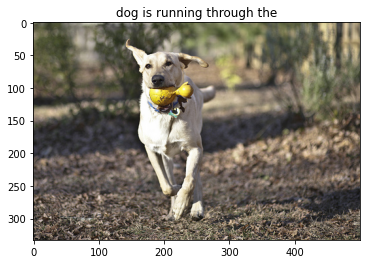

In [124]:
# random predict with test set
img = random.choice(test_images) 
feature_vector = test_features[img].reshape((1,2048))
x = plt.imread('/content/drive/MyDrive/Flickr8k/Images/' + img)
plt.imshow(x)
plt.title(greedySearch(feature_vector,0))
plt.show()

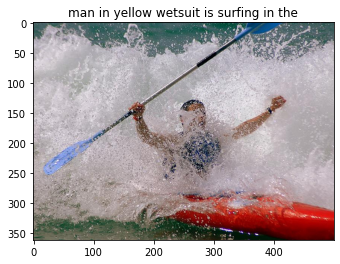

In [125]:
# random predict with test set
img = random.choice(valid_images) 
feature_vector = valid_features[img].reshape((1,2048))
x = plt.imread('/content/drive/MyDrive/Flickr8k/Images/' + img)
plt.imshow(x)
plt.title(greedySearch(feature_vector,0))
plt.show()

### predict new value

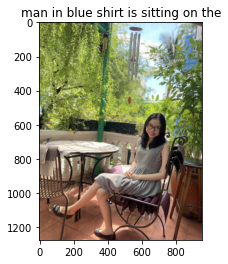

In [155]:
img = '/content/drive/MyDrive/IMG_20220619_075058.jpg'

# image embedding with feature_extractor
feature_vector = encode(img,feature_extractor) # (2048,)
feature_vector = feature_vector.reshape(1,2048)
x = plt.imread(img)
plt.imshow(x)
plt.title(greedySearch(feature_vector,0))
plt.show()

### references

[nntuan8](https://github.com/Locchuong96/Machine-Learning/blob/main/Courses/DL_Tutorial/L15/Automatic%20Image%20Captioning.ipynb)

[image caption](https://github.com/divyanshj16/Image-Captioning)

[image-caption-using-tensor-flow](https://www.kaggle.com/code/priyankasharma251997/image-caption-using-tensor-flow)

[bow-vs-skip-gram](https://www.baeldung.com/cs/word-embeddings-cbow-vs-skip-gram)

[word-embedding](https://lilianweng.github.io/posts/2017-10-15-word-embedding/)